In [17]:
from __future__ import division

import sys, time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import dblquad, simps

from abc import ABCMeta, abstractmethod

sns.set_context('talk', font_scale=1.5)
sns.set_style('darkgrid', {
    'axes.edgecolor': 'black',
    'axes.linewidth': 2,
    'lines.markeredgewidth': 1})

%matplotlib notebook

/usr/lib64/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [18]:
class Distribution(object):
    __metaclass__ = ABCMeta

    @abstractmethod
    def getValue(self, jx, jy):
        '''Return local pdf'''
        pass

    @abstractmethod
    def getDJx(self, jx, jy):
        '''Return derivation by Jx'''
        pass

    @abstractmethod
    def getDJy(self, jx, jy):
        '''Return derivation by Jy'''
        pass


class BiGaussian(Distribution):

    def getValue(self, jx, jy):
        '''Return pdf of normal bi-Gaussian'''
        return np.exp(-(jx + jy))

    def getDJx(self, jx, jy):
        return -self.getValue(jx, jy)

    def getDJy(self, jx, jy):
        return -self.getValue(jx, jy)

In [19]:
class Detuning(object):
    
    def __call__(self, jx, jy):
        raise NotImplemented

class Octupoles(object):

    def __init__(self, startTune=0.31, slopex=0, slopey=0):
        self._startTune = startTune
        self._slopex = slopex
        self._slopey = slopey

    def __call__(self, jx, jy):
        return self._startTune + self._slopex*jx + self._slopey*jy

In [20]:
class Dispersion(object):

    def __init__(self, distribution, detuning, Q, epsilon=1E-6):
        self.distribution = distribution
        self.detuning = detuning
        self.Q = Q
        self.epsilon = epsilon

    def getValue(self, jx, jy):
        DI = (
            (jx * self.distribution.getDJx(jx, jy)) /
            (self.Q - self.detuning(jx, jy) + 1j*self.epsilon)
             )

        return DI

In [24]:
class Integrator(object):

    __metaclass__ = ABCMeta

    def __init__(self, distribution, detuning, minJ=0.0, maxJ=18.0, **kwargs):
        self.distribution = distribution
        self.detuning = detuning
        self.minJx = minJ
        self.maxJx = maxJ
        self.minJy = minJ
        self.maxJy = maxJ

    @abstractmethod
    def integrate(self): pass

class DblquadIntegrator(Integrator):

    def __init__(self, distribution=None, detuning=None, minJ=0.0, maxJ=18.0):

        self.distribution = distribution
        self.detuning = detuning
        self.minJx = minJ
        self.maxJx = maxJ
        self.minJy = Boundary(minJ)
        self.maxJy = Boundary(maxJ)

    def integrate(self, Q):

        rDispersion = Dispersion(self.distribution, self.detuning, Q).real
        iDispersion = Dispersion(self.distribution, self.detuning, Q).imag

        realPart, realErr = dblquad(rDispersion, self.minJx, self.maxJx,
                                                 self.minJy, self.maxJy)
        imagPart, imagErr = dblquad(iDispersion, self.minJx, self.maxJx,
                                                 self.minJy, self.maxJy)

        return -1.0/complex(realPart, imagPart)
    
class SimpsonIntegrator(Integrator):

    def __init__(self, *args, **kwargs):

        super(SimpsonIntegrator, self).__init__(*args, **kwargs)

        if 'n_steps' not in kwargs: 
            kwargs['n_steps'] = 1000
        n_steps = kwargs['n_steps']
        self.jx = np.linspace(self.minJx, self.maxJx, n_steps)
        self.jy = np.linspace(self.minJy, self.maxJy, n_steps)
        self.JX, self.JY = np.meshgrid(self.jx, self.jy)

    def integrate(self, Q, epsilon=1e-6):

        dd = Dispersion(self.distribution, self.detuning, Q, epsilon=epsilon).getValue(self.JX, self.JY)
#         dd = np.array([[
#             Dispersion(self.distribution, self.detuning, Q, epsilon=epsilon).getValue(x, y)
#             for y in self.jy] for x in self.jx])

        return -1./simps(simps(dd, self.jx), self.jy)
    
class TrapzIntegrator(Integrator):

    def __init__(self, *args, **kwargs):

        super(TrapzIntegrator, self).__init__(*args, **kwargs)

        if 'n_steps' not in kwargs: 
            kwargs['n_steps'] = 1000
        n_steps = kwargs['n_steps']
        self.jx = np.linspace(self.minJx, self.maxJx, n_steps)
        self.jy = np.linspace(self.minJy, self.maxJy, n_steps)
        self.JX, self.JY = np.meshgrid(self.jx, self.jy)

    def integrate(self, Q, epsilon=1e-6):

        dd = Dispersion(self.distribution, self.detuning, Q, epsilon=epsilon).getValue(self.JX, self.JY)
        return -1./np.trapz(np.trapz(dd, self.jx), self.jy)

In [25]:
def findQs(detuning, stepSize=5E-5, maxJ=18.0, dJ=0.1, margin=1):
    '''
    '''
    myMin = 1.0
    myMax = 0.0
    for jx in np.arange(0, maxJ, dJ):
        for jy in np.arange(0, maxJ, dJ):
            value = detuning(jx, jy)
            if value < myMin :
                myMin = value
            if value > myMax :
                myMax = value
    return np.arange(myMin-margin*stepSize, myMax+margin*stepSize, stepSize)

def get_tune_range(detuning, maxJ=18.0, margin=1e-4, n_samples=100):
    myMin = 1.0
    myMax = 0.0
    for jx in np.linspace(0, maxJ, 100):
        for jy in np.linspace(0, maxJ, 100):
            value = detuning(jx, jy)
            if value < myMin :
                myMin = value
            if value > myMax :
                myMax = value
    return np.linspace(myMin - margin, myMax + margin, n_samples)

<IPython.core.display.Javascript object>


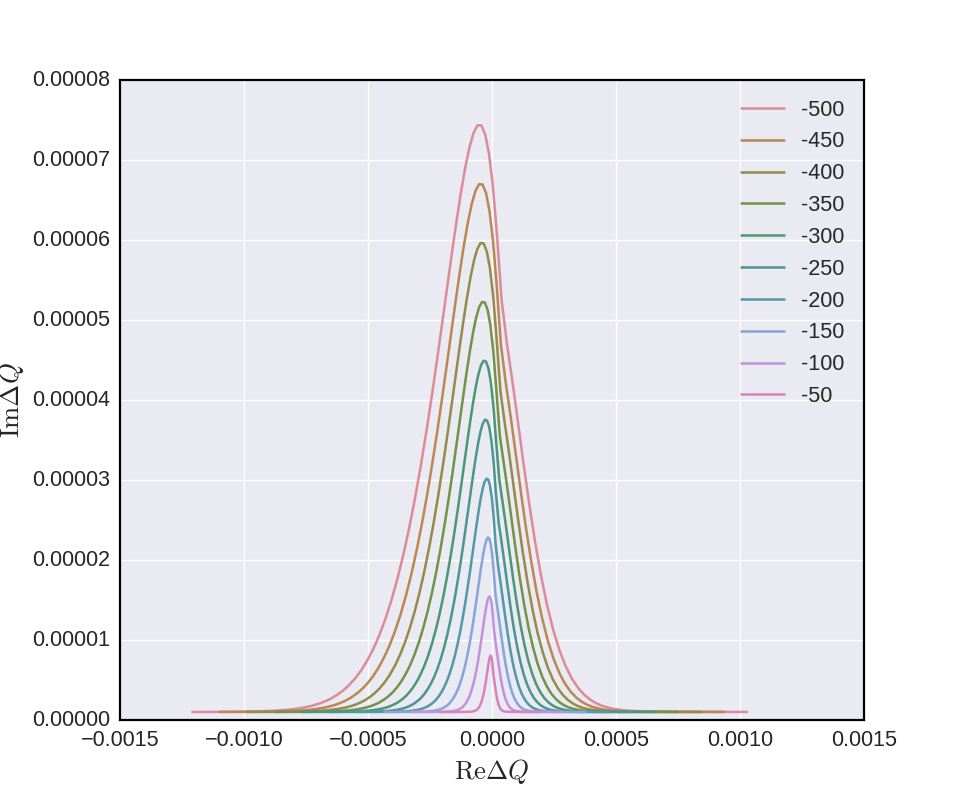

Elapsed times: 11.343s.
Elapsed times: 11.0403s.
Elapsed times: 11.7954s.
Elapsed times: 11.9634s.
Elapsed times: 11.5761s.
Elapsed times: 10.9734s.
Elapsed times: 10.9986s.
Elapsed times: 10.8168s.
Elapsed times: 10.9213s.
Elapsed times: 10.8272s.


In [26]:
energy = 7
emittance = 2e-6
i_octupoles = -500
i_octupoles = np.arange(-500, 0, 50)
a_x = 0.82*4 * i_octupoles*emittance/energy**2
a_y = -0.58*4 * i_octupoles*emittance/energy**2

distribution = BiGaussian()

fig, ax = plt.subplots(1, figsize=(12, 10))
col = sns.color_palette("husl", len(i_octupoles), 0.6)
for i, oct in enumerate(i_octupoles):
    detuning = Octupoles(.31, a_x[i], a_y[i])
    integrator = SimpsonIntegrator(distribution, detuning, maxJ=18)
#     integrator = TrapzIntegrator(distribution, detuning, maxJ=18)

    t0 = time.clock()
    tunes = get_tune_range(detuning)
    tune_shifts = np.zeros((len(tunes)), dtype='complex')
    for k, q in enumerate(tunes):
        tune_shifts[k] = integrator.integrate(q)
    t1 = time.clock()-t0

    print "Elapsed times: {:g}s.".format(t1)

    ax.plot(tune_shifts.real, tune_shifts.imag, c=col[i], label=oct)

ax.set_xlabel("$\operatorname{Re} \Delta Q$", fontsize=20)
ax.set_ylabel("$\operatorname{Im} \Delta Q$", fontsize=20)
ax.legend()

plt.show()

In [28]:
ax.set_xlabel("$\operatorname{Re} \Delta Q$", fontsize=24)
ax.set_ylabel("$\operatorname{Im} \Delta Q$", fontsize=24)
ax.legend()

plt.show()

In [ ]:
# FOOTPRINT DETUNING
# ==================
# dynaptune = True; ### TRUE : Use MADX output dynaptune as input. FALSE: Use output from Online Footprint Viewer
# inputFileName = 'dynaptyune_HO.txt'

# if dynaptune:
#     strRep = parseDynapTune(inputFileName, 101, 51); # set number of amplitude and angles in the file. (MADX + 1)
# else:
#     with open(inputFileName, "r") as fid:
#         strRep = fid.readline()

# footprint = Footprint(strRep,dSigma=0.1) # dSigma : amplitude difference between two indices in the amplitude loop (in unit of sigma)
# footprint.repair() # remove faulty points of the footprint
# detuning = FootprintDetuning(footprint)

# fp = footprint.getPlottable()

# plt.plot(fp[0], fp[1], '-')
# plt.show()